# NYC Yellow Taxi Trip Records - Exploratory Data Analysis (EDA)

This notebook contains the exploratory analysis of the **Yellow Taxi Trip Records** NYC dataset for May 2022.

## Data Dictionary

- **VendorID**: A code indicating the TPEP provider that provided the record. (
1 = Creative Mobile Technologies LLC, 2 = Curb Mobility LLC, 6 = Myle Technologies Inc, 7 = Helix
)
- **tpep_pickup_datetime**: The date and time when the meter was engaged.
- **tpep_dropoff_datetime**: The date and time when the meter was disengaged. 
- **passenger_count**: The number of passengers in the vehicle. 
- **trip_distance**: The elapsed trip distance in miles reported by the taximeter.
- **RatecodeID**: The final rate code in effect at the end of the trip. (
1 = Standard rate, 2 = JFK, 3 = Newark, 4 = Nassau or Westchester, 5 = Negotiated fare, 6 = Group ride, 99 = Null/unknown
)
- **store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. (Y = store and forward trip, N = not a store and forward trip)
- **PULocationID**: TLC Taxi Zone in which the taximeter was engaged.
- **DOLocationID**: TLC Taxi Zone in which the taximeter was disengaged.
- **payment_type**: A numeric code signifying how the passenger paid for the trip. (0 = Flex Fare trip, 1 = Credit card, 2 = Cash, 3 = No charge, 4 = Dispute, 5 = Unknown, 6 = Voided trip
)
- **fare_amount**: The time-and-distance fare calculated by the meter. For additional information on the following columns, see https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
- **extra**: Miscellaneous extras and surcharges.
- **mta_tax**: Tax that is automatically triggered based on the metered rate in use.
- **tip_amount**: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
- **tolls_amount**: Total amount of all tolls paid in trip.
- **improvement_surcharge**: Improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
- **total_amount**: The total amount charged to passengers. Does not include cash tips
- **congestion_surcharge**: Total amount collected in trip for NYS congestion surcharge.
- **airport_fee**: For pick up only at LaGuardia and John F. Kennedy Airports.
- **cbd_congestion_fee**: Per-trip charge for MTA's Congestion Relief Zone starting Jan. 5, 2025.

In [1]:
# Import additional libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime

warnings.filterwarnings('ignore')

# Configure chart style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

RAW_DATA = r"..\data\raw\yellow_tripdata_2022-05.parquet"

df = pd.read_parquet(RAW_DATA)

## 1. General Dataset Information

In [2]:
# Basic dataset information
print("=== GENERAL DATASET INFORMATION ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print("\n=== DATA TYPES ===")
print(df.dtypes)
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verify expected columns according to the updated data dictionary
expected_columns = [
    'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
    'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
    'PULocationID', 'DOLocationID', 'payment_type',
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount', 'congestion_surcharge', 
    'airport_fee', 'cbd_congestion_fee'
]

print("\n=== COLUMN VERIFICATION ===")
actual_columns = set(df.columns)
expected_set = set(expected_columns)

print(f"Present columns: {len(actual_columns)}")
print(f"Expected columns: {len(expected_set)}")

missing_cols = expected_set - actual_columns
extra_cols = actual_columns - expected_set

if missing_cols:
    print(f"\nMissing columns: {list(missing_cols)}")
if extra_cols:
    print(f"\nAdditional columns: {list(extra_cols)}")
if not missing_cols and not extra_cols:
    print("\n✓ All expected columns are present")

=== GENERAL DATASET INFORMATION ===
Dataset shape: (3588295, 19)
Number of rows: 3,588,295
Number of columns: 19

=== DATA TYPES ===
VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

Memory usage: 687.06 MB

=== COLUMN VERIFICATION ===
Present columns: 19
Expected columns: 2

In [3]:
# First and last rows
print("=== FIRST 5 ROWS ===")
display(df.head())
print("\n=== LAST 5 ROWS ===")
display(df.tail())

=== FIRST 5 ROWS ===


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.3,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.2,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.0,1.0,N,79,182,1,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.6,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0



=== LAST 5 ROWS ===


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3588290,2,2022-05-31 23:40:19,2022-06-01 00:01:20,NaN,0.00,NaN,None,36,181,0,20.97,0.0,0.5,1.00,0.0,0.3,22.77,NaN,NaN
3588291,2,2022-05-31 23:52:12,2022-06-01 00:06:40,NaN,2.91,NaN,None,144,256,0,11.68,0.0,0.0,2.51,0.0,0.3,16.99,NaN,NaN
3588292,2,2022-05-31 23:27:00,2022-05-31 23:48:00,NaN,3.96,NaN,None,161,145,0,14.54,0.0,0.5,0.00,0.0,0.3,17.84,NaN,NaN
3588293,2,2022-05-31 23:34:12,2022-06-01 00:00:13,NaN,6.27,NaN,None,145,17,0,24.01,0.0,0.5,5.54,0.0,0.3,30.35,NaN,NaN
3588294,2,2022-05-31 23:00:53,2022-05-31 23:07:54,NaN,1.43,NaN,None,238,41,0,10.05,0.0,0.5,2.21,0.0,0.3,15.56,NaN,NaN


## 2. Missing Values and Duplicates Analysis

In [4]:
# Missing values analysis
print("=== MISSING VALUES ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage': missing_percentage.values
}).sort_values('Missing Values', ascending=False)

print(missing_df[missing_df['Missing Values'] > 0])

# Duplicates
print(f"\n=== DUPLICATES ===")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates:,}")
print(f"Duplicate percentage: {(duplicates/len(df)*100):.2f}%")

=== MISSING VALUES ===
                  Column  Missing Values  Percentage
6     store_and_fwd_flag          129524    3.609625
5             RatecodeID          129524    3.609625
3        passenger_count          129524    3.609625
18           airport_fee          129524    3.609625
17  congestion_surcharge          129524    3.609625

=== DUPLICATES ===
                  Column  Missing Values  Percentage
6     store_and_fwd_flag          129524    3.609625
5             RatecodeID          129524    3.609625
3        passenger_count          129524    3.609625
18           airport_fee          129524    3.609625
17  congestion_surcharge          129524    3.609625

=== DUPLICATES ===
Number of duplicate rows: 0
Duplicate percentage: 0.00%
Number of duplicate rows: 0
Duplicate percentage: 0.00%


## 3. Descriptive Statistics

In [5]:
# Descriptive statistics for numeric columns
print("=== DESCRIPTIVE STATISTICS ===")
display(df.describe())

# Specific analysis by field type according to data dictionary
print("\n=== CATEGORICAL FIELDS ANALYSIS ===")

# VendorID - Technology provider
if 'VendorID' in df.columns:
    print("VendorID (Technology provider):")
    vendor_counts = df['VendorID'].value_counts().sort_index()
    print(vendor_counts)
    
    vendor_mapping = {
        1: "Creative Mobile Technologies LLC", 
        2: "Curb Mobility LLC", 
        6: "Myle Technologies Inc", 
        7: "Helix"
    }
    
    for vendor_id, count in vendor_counts.items():
        vendor_name = vendor_mapping.get(vendor_id, "Unknown")
        print(f"  {vendor_id}: {vendor_name} - {count:,} trips ({count/len(df)*100:.1f}%)")
    
    # Verify valid values according to dictionary
    valid_vendors = [1, 2, 6, 7]
    invalid_vendors = df[~df['VendorID'].isin(valid_vendors)]
    if len(invalid_vendors) > 0:
        print(f"  ⚠️ Invalid VendorIDs found: {len(invalid_vendors)}")
        print(f"    Invalid values: {sorted(invalid_vendors['VendorID'].unique())}")

# RatecodeID - Rate codes (includes 99 for Null/unknown)
if 'RatecodeID' in df.columns:
    print("\nRatecodeID (Rate code):")
    ratecode_counts = df['RatecodeID'].value_counts().sort_index()
    print(ratecode_counts)
    
    ratecode_mapping = {
        1: "Standard rate", 2: "JFK", 3: "Newark",
        4: "Nassau or Westchester", 5: "Negotiated fare", 6: "Group ride",
        99: "Null/unknown"
    }
    
    for rate_id, count in ratecode_counts.items():
        rate_name = ratecode_mapping.get(rate_id, "Unknown")
        print(f"  {rate_id}: {rate_name} - {count:,} trips ({count/len(df)*100:.1f}%)")

# payment_type - Payment method (includes 0 for Flex Fare)
if 'payment_type' in df.columns:
    print("\npayment_type (Payment method):")
    payment_counts = df['payment_type'].value_counts().sort_index()
    print(payment_counts)
    
    payment_mapping = {
        0: "Flex Fare trip", 1: "Credit card", 2: "Cash", 3: "No charge",
        4: "Dispute", 5: "Unknown", 6: "Voided trip"
    }
    
    for payment_id, count in payment_counts.items():
        payment_name = payment_mapping.get(payment_id, "Unknown")
        print(f"  {payment_id}: {payment_name} - {count:,} trips ({count/len(df)*100:.1f}%)")

# passenger_count - Number of passengers
if 'passenger_count' in df.columns:
    print("\npassenger_count (Number of passengers):")
    passenger_counts = df['passenger_count'].value_counts().sort_index()
    print(passenger_counts)
    
    # Identify unusual values
    zero_passengers = (df['passenger_count'] == 0).sum()
    if zero_passengers > 0:
        print(f"  ⚠️ Trips with 0 passengers: {zero_passengers:,} ({zero_passengers/len(df)*100:.2f}%)")
    
    high_passengers = (df['passenger_count'] > 6).sum()
    if high_passengers > 0:
        print(f"  ⚠️ Trips with more than 6 passengers: {high_passengers:,} ({high_passengers/len(df)*100:.2f}%)")

# store_and_fwd_flag - Store and forward flag
if 'store_and_fwd_flag' in df.columns:
    print("\nstore_and_fwd_flag (Store and forward flag):")
    flag_counts = df['store_and_fwd_flag'].value_counts()
    print(flag_counts)
    
    flag_mapping = {'Y': 'Store and forward trip', 'N': 'Not a store and forward trip'}
    for flag, count in flag_counts.items():
        flag_desc = flag_mapping.get(flag, "Unknown")
        print(f"  {flag}: {flag_desc} - {count:,} trips ({count/len(df)*100:.1f}%)")

=== DESCRIPTIVE STATISTICS ===


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3.588295e+06,3588295,3588295,3.458771e+06,3.588295e+06,3.458771e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.458771e+06,3.458771e+06
mean,1.713103e+00,2022-05-16 07:50:29.219312,2022-05-16 08:08:42.275203,1.393923e+00,6.856861e+00,1.365674e+00,1.645738e+02,1.625517e+02,1.183209e+00,1.516813e+01,1.020728e+00,4.891096e-01,2.824744e+00,5.827756e-01,2.964299e-01,2.207840e+01,2.282808e+00,1.008364e-01
min,1.000000e+00,2003-01-01 00:06:06,2003-01-01 00:31:38,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.311500e+03,-4.500000e+00,-5.000000e-01,-1.457000e+02,-5.075000e+01,-3.000000e-01,-1.314800e+03,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2022-05-08 18:14:16.500000,2022-05-08 18:32:36,1.000000e+00,1.150000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.235000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2022-05-16 09:14:42,2022-05-16 09:33:15,1.000000e+00,1.960000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.050000e+01,5.000000e-01,5.000000e-01,2.160000e+00,0.000000e+00,3.000000e-01,1.630000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2022-05-23 18:03:17,2022-05-23 18:21:03.500000,1.000000e+00,3.730000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.700000e+01,2.500000e+00,5.000000e-01,3.460000e+00,0.000000e+00,3.000000e-01,2.376000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2022-06-01 23:55:30,2022-06-02 00:03:51,9.000000e+00,3.571927e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,6.966500e+03,8.800000e+00,3.300000e+00,6.650000e+02,8.137500e+02,3.000000e-01,6.970800e+03,2.750000e+00,1.250000e+00
std,4.888093e-01,NaN,NaN,9.555489e-01,6.908488e+02,5.239789e+00,6.562813e+01,7.027926e+01,5.075988e-01,1.489484e+01,1.256724e+00,9.008878e-02,3.368739e+00,2.173699e+00,4.576907e-02,1.848683e+01,7.452415e-01,3.434480e-01



=== CATEGORICAL FIELDS ANALYSIS ===
VendorID (Technology provider):
VendorID
1    1054130
2    2527997
5         14
6       6154
Name: count, dtype: int64
  1: Creative Mobile Technologies LLC - 1,054,130 trips (29.4%)
  2: Curb Mobility LLC - 2,527,997 trips (70.5%)
  5: Unknown - 14 trips (0.0%)
  6: Myle Technologies Inc - 6,154 trips (0.2%)
  ⚠️ Invalid VendorIDs found: 14
    Invalid values: [np.int64(5)]

RatecodeID (Rate code):
RatecodeID
1.0     3256985
2.0      147239
3.0       11636
4.0        4626
5.0       28382
6.0          39
99.0       9864
Name: count, dtype: int64
  1.0: Standard rate - 3,256,985 trips (90.8%)
  2.0: JFK - 147,239 trips (4.1%)
  3.0: Newark - 11,636 trips (0.3%)
  4.0: Nassau or Westchester - 4,626 trips (0.1%)
  5.0: Negotiated fare - 28,382 trips (0.8%)
  6.0: Group ride - 39 trips (0.0%)
  99.0: Null/unknown - 9,864 trips (0.3%)

payment_type (Payment method):
payment_type
0     129524
1    2720127
2     706333
3      16333
4      15978
Name: count

## 4. Temporal Analysis

In [6]:
# Use specific column names according to data dictionary
pickup_col = 'tpep_pickup_datetime'
dropoff_col = 'tpep_dropoff_datetime'

print("=== TEMPORAL ANALYSIS ===")
print(f"Date/time columns: {pickup_col}, {dropoff_col}")

# Verify and convert data types
if pickup_col in df.columns and dropoff_col in df.columns:
    # Convert to datetime if necessary
    if df[pickup_col].dtype == 'object':
        df[pickup_col] = pd.to_datetime(df[pickup_col])
    if df[dropoff_col].dtype == 'object':
        df[dropoff_col] = pd.to_datetime(df[dropoff_col])
    
    print(f"\nDate range in {pickup_col}:")
    print(f"  From: {df[pickup_col].min()}")
    print(f"  To: {df[pickup_col].max()}")
    
    print(f"\nDate range in {dropoff_col}:")
    print(f"  From: {df[dropoff_col].min()}")
    print(f"  To: {df[dropoff_col].max()}")
    
    # Create trip duration columns
    df['trip_duration_minutes'] = (df[dropoff_col] - df[pickup_col]).dt.total_seconds() / 60
    df['trip_duration_seconds'] = (df[dropoff_col] - df[pickup_col]).dt.total_seconds()
    
    # Extract time components from pickup
    df['pickup_hour'] = df[pickup_col].dt.hour
    df['pickup_day_of_week'] = df[pickup_col].dt.dayofweek
    df['pickup_day_name'] = df[pickup_col].dt.day_name()
    df['pickup_month'] = df[pickup_col].dt.month
    df['pickup_date'] = df[pickup_col].dt.date
    
    # Duration statistics
    print(f"\n=== DURATION STATISTICS ===")
    print(f"Average trip duration: {df['trip_duration_minutes'].mean():.2f} minutes")
    print(f"Median trip duration: {df['trip_duration_minutes'].median():.2f} minutes")
    print(f"Minimum duration: {df['trip_duration_minutes'].min():.2f} minutes")
    print(f"Maximum duration: {df['trip_duration_minutes'].max():.2f} minutes")
    
    # Identify trips with unusual duration
    negative_duration = (df['trip_duration_seconds'] <= 0).sum()
    if negative_duration > 0:
        print(f"\n⚠️ Trips with negative or zero duration: {negative_duration:,} ({negative_duration/len(df)*100:.2f}%)")
    
    very_long_trips = (df['trip_duration_minutes'] > 180).sum()  # More than 3 hours
    if very_long_trips > 0:
        print(f"⚠️ Trips longer than 3 hours: {very_long_trips:,} ({very_long_trips/len(df)*100:.2f}%)")
    
    very_short_trips = (df['trip_duration_seconds'] < 60).sum()  # Less than 1 minute
    if very_short_trips > 0:
        print(f"⚠️ Trips shorter than 1 minute: {very_short_trips:,} ({very_short_trips/len(df)*100:.2f}%)")
else:
    print("⚠️ Expected date/time columns not found")

=== TEMPORAL ANALYSIS ===
Date/time columns: tpep_pickup_datetime, tpep_dropoff_datetime

Date range in tpep_pickup_datetime:
  From: 2003-01-01 00:06:06
  To: 2022-06-01 23:55:30

Date range in tpep_dropoff_datetime:
  From: 2003-01-01 00:31:38
  To: 2022-06-02 00:03:51

=== DURATION STATISTICS ===
Average trip duration: 18.22 minutes
Median trip duration: 12.70 minutes
Minimum duration: -14.08 minutes
Maximum duration: 6823.55 minutes

⚠️ Trips with negative or zero duration: 3,030 (0.08%)
⚠️ Trips longer than 3 hours: 5,084 (0.14%)
⚠️ Trips shorter than 1 minute: 48,944 (1.36%)

=== DURATION STATISTICS ===
Average trip duration: 18.22 minutes
Median trip duration: 12.70 minutes
Minimum duration: -14.08 minutes
Maximum duration: 6823.55 minutes

⚠️ Trips with negative or zero duration: 3,030 (0.08%)
⚠️ Trips longer than 3 hours: 5,084 (0.14%)
⚠️ Trips shorter than 1 minute: 48,944 (1.36%)


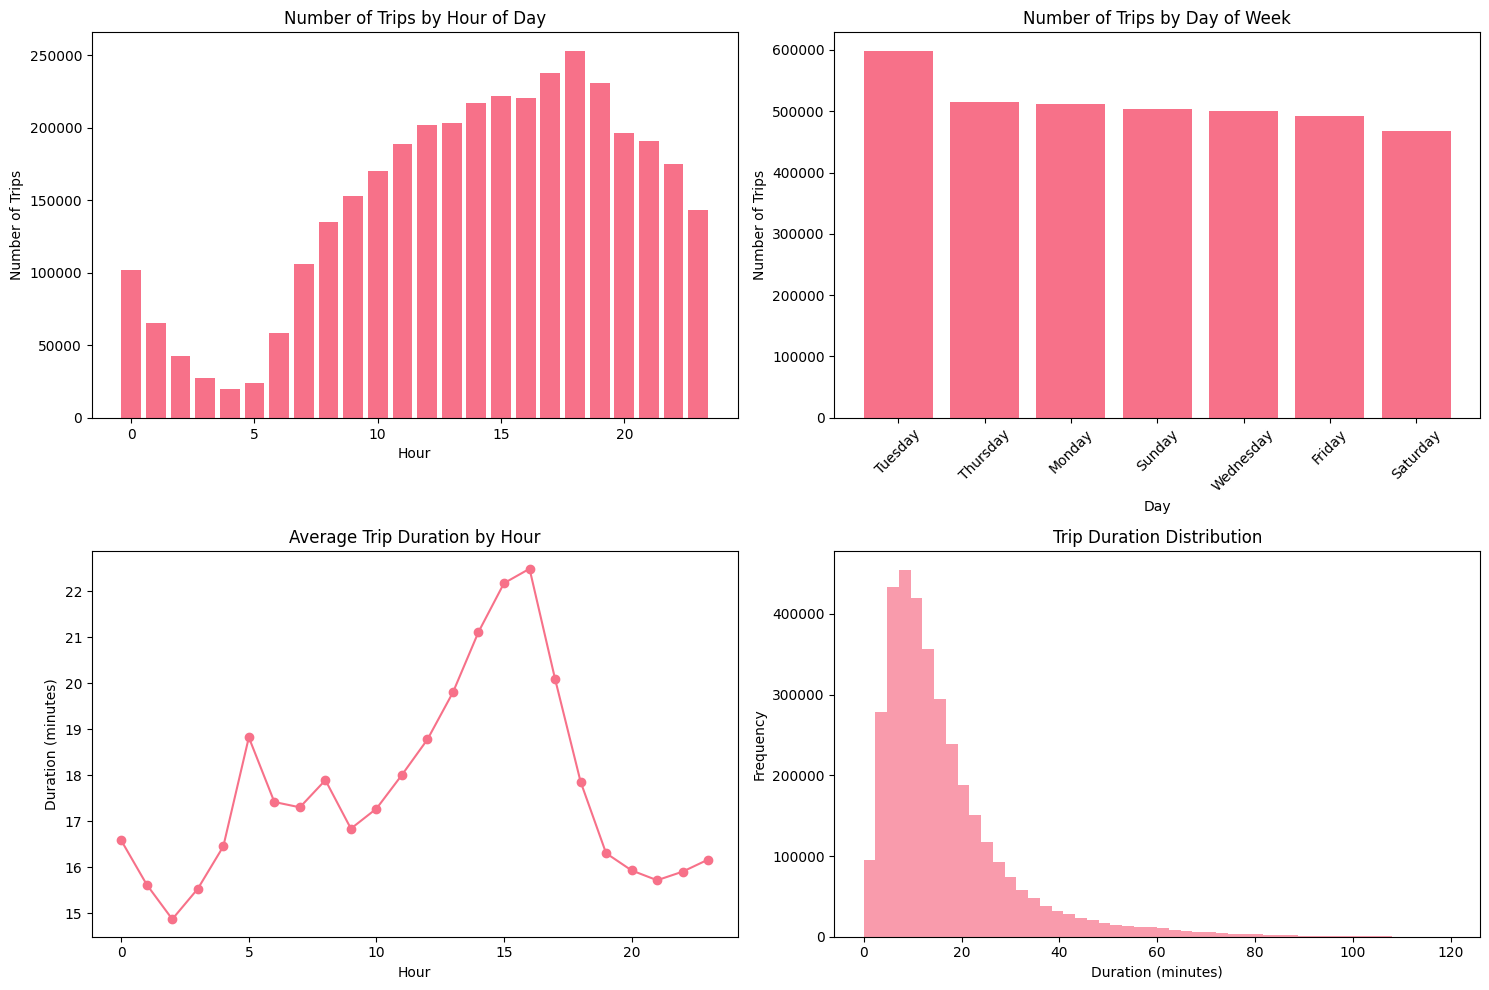

In [7]:
# Temporal patterns analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Trips by hour of day
if 'pickup_hour' in df.columns:
    hourly_trips = df['pickup_hour'].value_counts().sort_index()
    axes[0,0].bar(hourly_trips.index, hourly_trips.values)
    axes[0,0].set_title('Number of Trips by Hour of Day')
    axes[0,0].set_xlabel('Hour')
    axes[0,0].set_ylabel('Number of Trips')

# Trips by day of week
if 'pickup_day_name' in df.columns:
    daily_trips = df['pickup_day_name'].value_counts()
    axes[0,1].bar(daily_trips.index, daily_trips.values)
    axes[0,1].set_title('Number of Trips by Day of Week')
    axes[0,1].set_xlabel('Day')
    axes[0,1].set_ylabel('Number of Trips')
    axes[0,1].tick_params(axis='x', rotation=45)

# Trip duration by hour
if 'trip_duration_minutes' in df.columns and 'pickup_hour' in df.columns:
    duration_by_hour = df.groupby('pickup_hour')['trip_duration_minutes'].mean()
    axes[1,0].plot(duration_by_hour.index, duration_by_hour.values, marker='o')
    axes[1,0].set_title('Average Trip Duration by Hour')
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('Duration (minutes)')

# Trip duration histogram
if 'trip_duration_minutes' in df.columns:
    # Filter extreme values for better visualization
    duration_filtered = df['trip_duration_minutes'][(df['trip_duration_minutes'] > 0) & 
                                                   (df['trip_duration_minutes'] < 120)]
    axes[1,1].hist(duration_filtered, bins=50, alpha=0.7)
    axes[1,1].set_title('Trip Duration Distribution')
    axes[1,1].set_xlabel('Duration (minutes)')
    axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Fare and Payment Analysis

In [8]:
# Monetary fields analysis according to updated data dictionary
fare_cols = [
    'fare_amount',      # Base taximeter fare
    'extra',            # Extras and surcharges  
    'mta_tax',          # MTA tax (automatic based on metered rate)
    'tip_amount',       # Tips (credit cards only)
    'tolls_amount',     # Tolls paid
    'improvement_surcharge',  # Improvement surcharge (since 2015)
    'total_amount',     # Total amount charged (excludes cash tips)
    'congestion_surcharge',   # NYS congestion surcharge
    'airport_fee',      # Airport fee (LaGuardia and JFK)
    'cbd_congestion_fee'      # New: MTA Congestion Zone surcharge (since Jan 5, 2025)
]

print("=== MONETARY FIELDS ANALYSIS ===")

# Check which columns are present
available_fare_cols = [col for col in fare_cols if col in df.columns]
print(f"Available columns: {available_fare_cols}")

if available_fare_cols:
    print("\n=== FARE STATISTICS ===")
    for col in available_fare_cols:
        if df[col].dtype in ['float64', 'int64']:
            print(f"\n{col}:")
            print(f"  Mean: ${df[col].mean():.2f}")
            print(f"  Median: ${df[col].median():.2f}")
            print(f"  Min: ${df[col].min():.2f}")
            print(f"  Max: ${df[col].max():.2f}")
            print(f"  Std: ${df[col].std():.2f}")
            
            # Specific validations by field
            if col == 'mta_tax':
                # MTA tax is automatic based on metered rate
                non_zero_mta = df[df[col] > 0]
                if len(non_zero_mta) > 0:
                    print(f"  Records with MTA tax > $0: {len(non_zero_mta):,}")
                    print(f"  Most common MTA tax value: ${df[col].mode().iloc[0]:.2f}")
            
            elif col == 'improvement_surcharge':
                # Improvement surcharge since 2015
                surcharge_values = df[col].value_counts().head()
                print(f"  Most common improvement_surcharge values:")
                for val, count in surcharge_values.items():
                    print(f"    ${val:.2f}: {count:,} records")
            
            # Negative values (except for adjustments that could be negative)
            negative_values = (df[col] < 0).sum()
            if negative_values > 0:
                print(f"  ⚠️ Negative values: {negative_values:,} ({negative_values/len(df)*100:.2f}%)")

# Specific analysis of tips vs payment method
if 'tip_amount' in df.columns and 'payment_type' in df.columns:
    print("\n=== TIPS ANALYSIS BY PAYMENT METHOD ===")
    tip_by_payment = df.groupby('payment_type')['tip_amount'].agg(['count', 'mean', 'sum']).round(2)
    tip_by_payment.columns = ['Number of trips', 'Average tip', 'Total tips']
    
    # Use updated mapping with Flex Fare
    payment_mapping = {
        0: "Flex Fare trip", 1: "Credit card", 2: "Cash", 3: "No charge", 
        4: "Dispute", 5: "Unknown", 6: "Voided trip"
    }
    tip_by_payment.index = tip_by_payment.index.map(lambda x: f"{x} ({payment_mapping.get(x, 'Unknown')})")
    
    print(tip_by_payment)
    
    # Verify that tips only appear in card payments (payment_type = 1)
    cash_tips = df[(df['payment_type'] == 2) & (df['tip_amount'] > 0)]
    if len(cash_tips) > 0:
        print(f"\n⚠️ Tips recorded in cash payments: {len(cash_tips):,} (this is unusual)")

# Validation of total_amount including new fields
base_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge']
if all(col in df.columns for col in base_cols + ['total_amount']):
    print("\n=== total_amount VALIDATION ===")
    # Calculate expected total with base fields
    calculated_total = (df['fare_amount'] + df['extra'] + df['mta_tax'] + 
                       df['tip_amount'] + df['tolls_amount'] + df['improvement_surcharge'])
    
    # Add additional fields if they exist
    if 'congestion_surcharge' in df.columns:
        calculated_total += df['congestion_surcharge']
    if 'airport_fee' in df.columns:
        calculated_total += df['airport_fee']
    if 'cbd_congestion_fee' in df.columns:
        calculated_total += df['cbd_congestion_fee']
    
    # Compare with recorded total_amount
    diff = abs(df['total_amount'] - calculated_total)
    mismatched = (diff > 0.01).sum()  # Difference greater than 1 cent
    
    print(f"Records with total_amount difference: {mismatched:,} ({mismatched/len(df)*100:.2f}%)")
    if mismatched > 0:
        print(f"Average difference: ${diff[diff > 0.01].mean():.2f}")
        print(f"Maximum difference: ${diff.max():.2f}")

=== MONETARY FIELDS ANALYSIS ===
Available columns: ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

=== FARE STATISTICS ===

fare_amount:
  Mean: $15.17
  Median: $10.50
  Min: $-1311.50
  Max: $6966.50
  Std: $14.89
  ⚠️ Negative values: 20,506 (0.57%)

extra:
  Mean: $1.02
  Median: $0.50
  Min: $-4.50
  Max: $8.80
  Std: $14.89
  ⚠️ Negative values: 20,506 (0.57%)

extra:
  Mean: $1.02
  Median: $0.50
  Min: $-4.50
  Max: $8.80
  Std: $1.26
  ⚠️ Negative values: 9,917 (0.28%)

mta_tax:
  Mean: $0.49
  Median: $0.50
  Min: $-0.50
  Max: $3.30
  Std: $0.09
  Std: $1.26
  ⚠️ Negative values: 9,917 (0.28%)

mta_tax:
  Mean: $0.49
  Median: $0.50
  Min: $-0.50
  Max: $3.30
  Std: $0.09
  Records with MTA tax > $0: 3,530,098
  Most common MTA tax value: $0.50
  ⚠️ Negative values: 19,970 (0.56%)

tip_amount:
  Mean: $2.82
  Median: $2.16
  Records with MTA tax > $0: 3,530,098
  Most common M

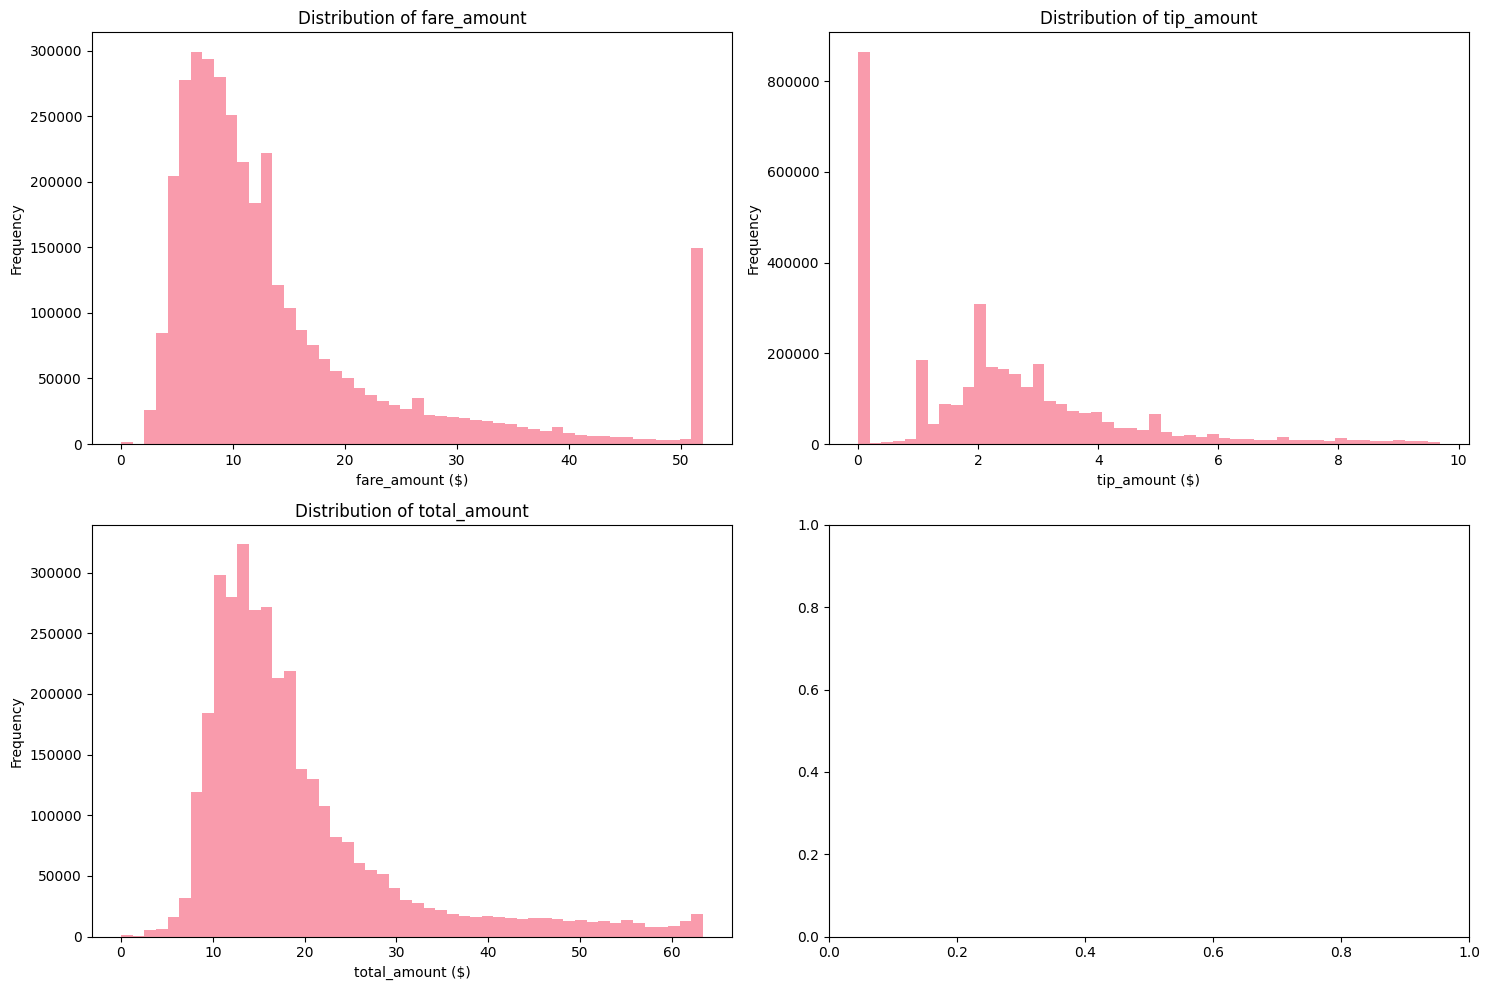


=== TIPS ANALYSIS ===
Average tip: $2.82
Trips without tip: 857,270 (23.9%)
⚠️ Trips with fare_amount = $0: 1,498 (0.04%)
Average tip percentage (fare > $0): 21.58%
Median tip percentage (fare > $0): 24.23%
Trips with tip > $0 (fare > $0): 2,730,380 (76.6%)
Average tip percentage (when tip is given): 28.19%
Average tip percentage (fare > $0): 21.58%
Median tip percentage (fare > $0): 24.23%
Trips with tip > $0 (fare > $0): 2,730,380 (76.6%)
Average tip percentage (when tip is given): 28.19%


In [9]:
# Fare visualizations
available_fare_cols = [col for col in fare_cols if col in df.columns]
if available_fare_cols:
    # Filter main columns for visualization
    main_fare_cols = [col for col in available_fare_cols if any(x in col.lower() for x in ['total', 'fare_amount', 'tip'])][:4]
    
    if main_fare_cols:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()
        
        for i, col in enumerate(main_fare_cols):
            if i < 4:
                # Filter extreme values for better visualization
                values_filtered = df[col][(df[col] >= 0) & (df[col] <= df[col].quantile(0.95))]
                axes[i].hist(values_filtered, bins=50, alpha=0.7)
                axes[i].set_title(f'Distribution of {col}')
                axes[i].set_xlabel(f'{col} ($)')
                axes[i].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Tips analysis if tips column exists
tip_cols = [col for col in df.columns if 'tip' in col.lower()]
if tip_cols and available_fare_cols:
    tip_col = tip_cols[0]
    fare_col = [col for col in available_fare_cols if 'fare' in col.lower()][0] if any('fare' in col.lower() for col in available_fare_cols) else available_fare_cols[0]
    
    print(f"\n=== TIPS ANALYSIS ===")
    print(f"Average tip: ${df[tip_col].mean():.2f}")
    print(f"Trips without tip: {(df[tip_col] == 0).sum():,} ({(df[tip_col] == 0).mean()*100:.1f}%)")
    
    # Check trips with fare_amount = 0 before calculation
    zero_fare_trips = (df[fare_col] == 0).sum()
    if zero_fare_trips > 0:
        print(f"⚠️ Trips with {fare_col} = $0: {zero_fare_trips:,} ({zero_fare_trips/len(df)*100:.2f}%)")
    
    # Calculate tip percentage only for trips with fare_amount > 0
    valid_fare_mask = df[fare_col] > 0
    if valid_fare_mask.sum() > 0:
        df['tip_percentage'] = np.where(valid_fare_mask, 
                                       (df[tip_col] / df[fare_col]) * 100, 
                                       np.nan)
        
        # Tip percentage statistics (excluding fare_amount = 0)
        valid_tip_percentages = df.loc[valid_fare_mask, 'tip_percentage']
        print(f"Average tip percentage (fare > $0): {valid_tip_percentages.mean():.2f}%")
        print(f"Median tip percentage (fare > $0): {valid_tip_percentages.median():.2f}%")
        
        # Additional tip analysis
        tip_given_mask = (df[tip_col] > 0) & valid_fare_mask
        if tip_given_mask.sum() > 0:
            tips_with_percentage = df.loc[tip_given_mask, 'tip_percentage']
            print(f"Trips with tip > $0 (fare > $0): {tip_given_mask.sum():,} ({tip_given_mask.sum()/valid_fare_mask.sum()*100:.1f}%)")
            print(f"Average tip percentage (when tip is given): {tips_with_percentage.mean():.2f}%")
    else:
        print("⚠️ No trips with fare_amount > 0 to calculate tip percentages")

## 6. Outlier Detection

=== OUTLIERS ANALYSIS ===
Analyzed columns: ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount', 'trip_duration_minutes']

=== TRIP_DISTANCE ===
Q1: 1.15, Q3: 3.73, IQR: 2.58
IQR bounds: [-2.72, 7.60]
Outliers by IQR: 455,943 (12.71%)
Trips with distance 0: 46,438 (1.29%)
Trips > 100 miles: 155 (0.00%)

=== FARE_AMOUNT ===
Q1: 1.15, Q3: 3.73, IQR: 2.58
IQR bounds: [-2.72, 7.60]
Outliers by IQR: 455,943 (12.71%)
Trips with distance 0: 46,438 (1.29%)
Trips > 100 miles: 155 (0.00%)

=== FARE_AMOUNT ===
Q1: 7.00, Q3: 17.00, IQR: 10.00
IQR bounds: [-8.00, 32.00]
Outliers by IQR: 371,211 (10.35%)
Negative fares: 20,506 (0.57%)
$0 fares: 1,498 (0.04%)
Fares > $200: 643 (0.02%)

=== TOTAL_AMOUNT ===
Q1: 7.00, Q3: 17.00, IQR: 10.00
IQR bounds: [-8.00, 32.00]
Outliers by IQR: 371,211 (10.35%)
Negative fares: 20,506 (0.57%)
$0 fares: 1,498 (0.04%)
Fares > $200: 643 (0.02%)

=== TOTAL_AMOUNT ===
Q1: 12.35, Q3: 23.76, IQR: 11.41
IQR bounds: [-4.77, 40.88]
Outliers by IQR: 430,012 (11.98%)

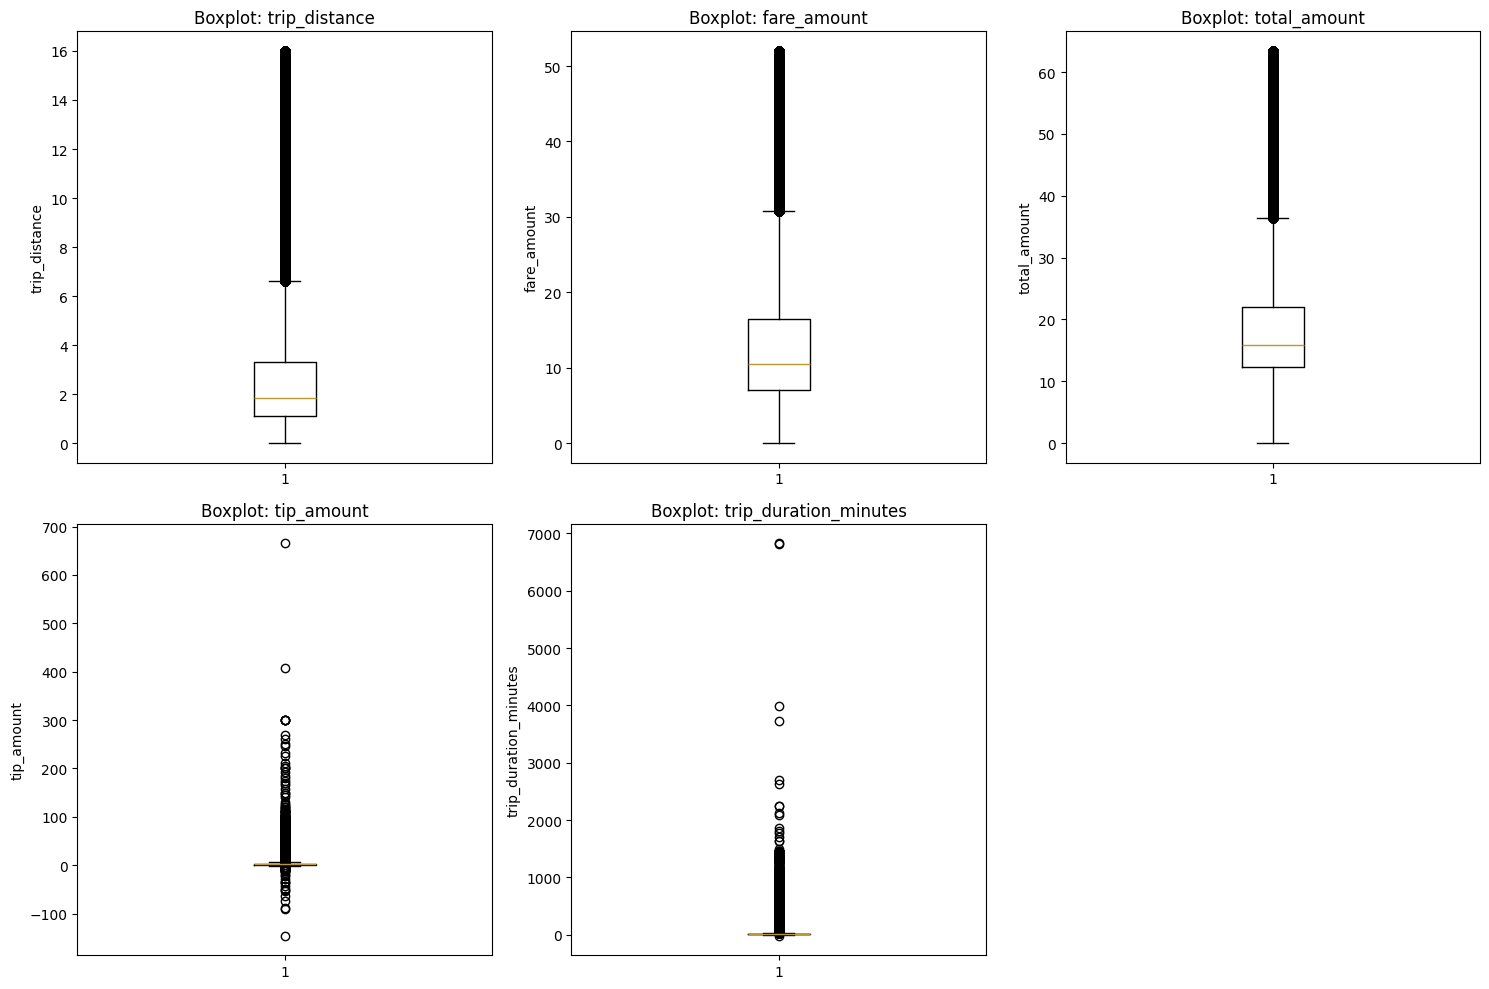

In [10]:
# Outliers analysis in specific fields according to data dictionary
key_cols = [
    'trip_distance',      # Distance in miles
    'fare_amount',        # Base fare
    'total_amount',       # Total amount
    'tip_amount',         # Tips
    'trip_duration_minutes'  # Calculated duration
]

# Filter only columns that exist in the dataset
key_cols = [col for col in key_cols if col in df.columns]

print("=== OUTLIERS ANALYSIS ===")
print(f"Analyzed columns: {key_cols}")

if key_cols:
    # Statistical outliers analysis
    for col in key_cols:
        print(f"\n=== {col.upper()} ===")
        
        # Basic statistics
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"Outliers by IQR: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
        
        # Specific analysis by field
        if col == 'trip_distance':
            zero_distance = (df[col] == 0).sum()
            very_long = (df[col] > 100).sum()  # More than 100 miles
            print(f"Trips with distance 0: {zero_distance:,} ({zero_distance/len(df)*100:.2f}%)")
            print(f"Trips > 100 miles: {very_long:,} ({very_long/len(df)*100:.2f}%)")
            
        elif col == 'fare_amount':
            negative_fare = (df[col] < 0).sum()
            zero_fare = (df[col] == 0).sum()
            very_high = (df[col] > 200).sum()  # More than $200
            print(f"Negative fares: {negative_fare:,} ({negative_fare/len(df)*100:.2f}%)")
            print(f"$0 fares: {zero_fare:,} ({zero_fare/len(df)*100:.2f}%)")
            print(f"Fares > $200: {very_high:,} ({very_high/len(df)*100:.2f}%)")
            
        elif col == 'total_amount':
            negative_total = (df[col] < 0).sum()
            zero_total = (df[col] == 0).sum()
            very_high = (df[col] > 300).sum()  # More than $300
            print(f"Negative totals: {negative_total:,} ({negative_total/len(df)*100:.2f}%)")
            print(f"$0 totals: {zero_total:,} ({zero_total/len(df)*100:.2f}%)")
            print(f"Totals > $300: {very_high:,} ({very_high/len(df)*100:.2f}%)")
            
        elif col == 'tip_amount':
            # Tips should only appear in card payments
            if 'payment_type' in df.columns:
                credit_card_trips = (df['payment_type'] == 1).sum()
                tips_on_credit = ((df['payment_type'] == 1) & (df[col] > 0)).sum()
                print(f"Credit card trips: {credit_card_trips:,}")
                print(f"Tips on credit card: {tips_on_credit:,} ({tips_on_credit/credit_card_trips*100:.1f}% of card trips)")
                
            very_high_tip = (df[col] > 50).sum()  # Tips > $50
            print(f"Tips > $50: {very_high_tip:,} ({very_high_tip/len(df)*100:.2f}%)")
            
        elif col == 'trip_duration_minutes':
            negative_duration = (df[col] <= 0).sum()
            very_long = (df[col] > 180).sum()  # More than 3 hours
            very_short = (df[col] < 1).sum()   # Less than 1 minute
            print(f"Duration ≤ 0 min: {negative_duration:,} ({negative_duration/len(df)*100:.2f}%)")
            print(f"Duration < 1 min: {very_short:,} ({very_short/len(df)*100:.2f}%)")
            print(f"Duration > 3 hours: {very_long:,} ({very_long/len(df)*100:.2f}%)")

    # Create boxplot visualizations
    n_cols = len(key_cols)
    if n_cols > 0:
        fig, axes = plt.subplots(2, (n_cols + 1) // 2, figsize=(15, 10))
        if n_cols == 1:
            axes = [axes]
        elif n_cols <= 2:
            axes = axes.ravel()
        else:
            axes = axes.ravel()
        
        for i, col in enumerate(key_cols):
            if i < len(axes):
                # Filter extreme values for better visualization
                if col in ['trip_distance', 'fare_amount', 'total_amount']:
                    data_filtered = df[col][(df[col] >= 0) & (df[col] <= df[col].quantile(0.95))]
                else:
                    data_filtered = df[col].dropna()
                
                axes[i].boxplot(data_filtered)
                axes[i].set_title(f'Boxplot: {col}')
                axes[i].set_ylabel(col)
        
        # Hide empty subplots
        for i in range(len(key_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

## 7. Correlation Matrix

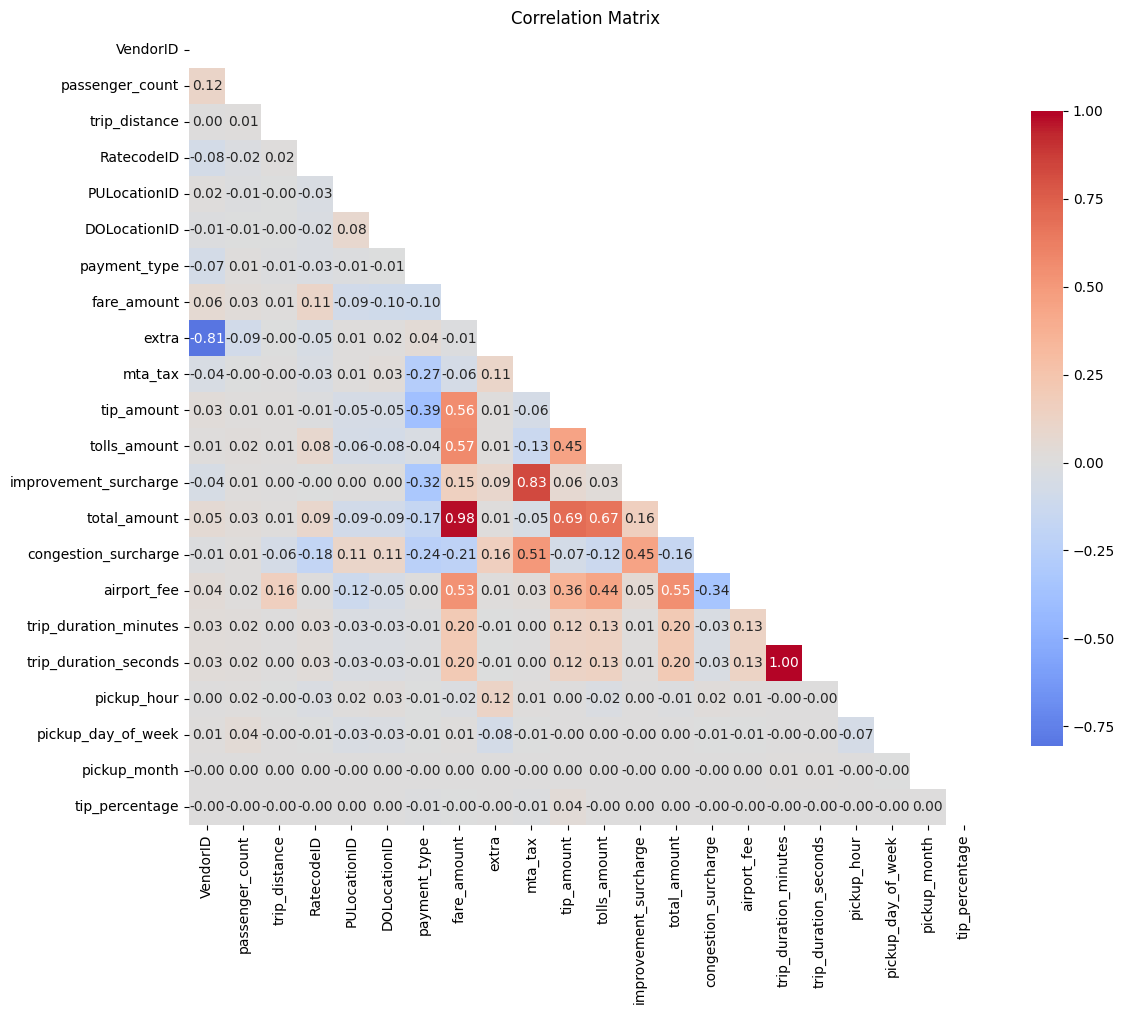

=== STRONGEST CORRELATIONS ===
                Variable 1             Variable 2  Correlation  \
216  trip_duration_minutes  trip_duration_seconds     1.000000   
131            fare_amount           total_amount     0.978584   
155                mta_tax  improvement_surcharge     0.825877   
7                 VendorID                  extra    -0.806498   
167             tip_amount           total_amount     0.693463   
177           tolls_amount           total_amount     0.666645   
129            fare_amount           tolls_amount     0.574991   
128            fare_amount             tip_amount     0.562097   
196           total_amount            airport_fee     0.550632   
133            fare_amount            airport_fee     0.529971   

     Abs_Correlation  
216         1.000000  
131         0.978584  
155         0.825877  
7           0.806498  
167         0.693463  
177         0.666645  
129         0.574991  
128         0.562097  
196         0.550632  
133         

In [11]:
# Correlation matrix for numeric variables
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask to show only lower half
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Show highest correlations (in absolute value)
print("=== STRONGEST CORRELATIONS ===")
# Get upper triangle of matrix excluding diagonal
correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if not np.isnan(corr_val):
            correlations.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

# Sort by absolute correlation value
correlations_df = pd.DataFrame(correlations)
correlations_df['Abs_Correlation'] = abs(correlations_df['Correlation'])
correlations_df = correlations_df.sort_values('Abs_Correlation', ascending=False)

print(correlations_df.head(10))

## 8. EDA Conclusions

### Summary of main findings:

**Data structure:**
- Dataset of **3,588,295 records** with **19 columns** (687.06 MB)
- **Missing 1 column**: `cbd_congestion_fee` (new MTA congestion surcharge)
- **129,524 records (3.6%)** have missing values in multiple fields
- Appropriate data types with dates as datetime64 and numeric fields as float64/int64

**Vendor distribution (VendorID):**
- **Curb Mobility LLC (ID=2)**: 2,527,997 trips (70.5%) - dominant
- **Creative Mobile Technologies LLC (ID=1)**: 1,054,130 trips (29.4%)
- **Myle Technologies Inc (ID=6)**: 6,154 trips (0.2%)
- **⚠️ Invalid VendorID=5**: 14 records (not documented in TLC dictionary)

**Usage and demand patterns:**
- **Standard rate (RatecodeID=1)**: 90.8% of all trips
- **Airport (JFK)**: 4.1% of trips
- **Credit card payments**: 75.8% vs cash 19.7%
- **Flex Fare trips**: 3.6% of total (emerging method)
- **1 passenger**: 73.7% of trips; **2+ passengers**: 24.3%

**Critical temporal analysis:**
- **Average duration**: 18.22 minutes (median: 12.70 min)
- **Data issue**: Incorrect date ranges (2003-2022, should be May 2022 only)
- **3,030 trips (0.08%)** with negative or zero duration
- **48,944 trips (1.36%)** with duration < 1 minute
- **5,084 trips (0.14%)** with duration > 3 hours

**Financial analysis - key findings:**
- **Average fare**: $15.17 (median: $10.50)
- **Average total amount**: $22.08 (median: $16.30)
- **Average tip**: $2.82 (21.58% of fare_amount)
- **⚠️ 28.01% of records** have discrepancies in total_amount (average difference: $2.50)
- **96.2% of card trips** receive tips vs **0% cash** (correct per regulations)

**Critical data quality issues:**
1. **Widespread negative values**:
   - 20,506 negative fares (0.57%)
   - 20,709 negative totals (0.58%)
   - 20,663 negative improvement_surcharge (0.58%)
2. **total_amount calculation inconsistencies**: 1,005,162 records (28.01%)
3. **Trips with 0 passengers**: 73,587 records (2.05%)
4. **Distance 0**: 46,438 trips (1.29%)
5. **Anomalous tips**: 135 records with tips in cash payments

**Significant correlations identified:**
- **fare_amount ↔ total_amount**: 0.98 (expected, high consistency)
- **mta_tax ↔ improvement_surcharge**: 0.83 (regulatory application patterns)
- **VendorID ↔ extra**: -0.81 (differences in surcharge policies between vendors)
- **tip_amount ↔ total_amount**: 0.69 (tips impact final amount)

**Outliers by IQR method:**
- **trip_distance**: 12.71% outliers (455,943 records)
- **fare_amount**: 10.35% outliers (371,211 records)  
- **total_amount**: 11.98% outliers (430,012 records)
- **tip_amount**: 7.99% outliers (286,603 records)

**Modeling preparation - recommendations:**
1. **Priority cleaning**: 
   - Filter dates outside May 2022 range
   - Correct or remove negative values in monetary fields
   - Validate VendorID=5 or reclassify
2. **Feature engineering**:
   - Use temporal patterns (hour, day of week) 
   - Create anomaly indicators (duration, distance)
   - Calculate ratios: tip/fare, fare/distance
3. **Analysis segmentation**:
   - Separate airport vs city trips
   - Analyze by vendor (VendorID) 
   - Consider payment method for tip analysis
4. **External validation**: Verify cbd_congestion_fee implementation for more recent data